In [20]:
%autosave 0

import numpy as np
import pandas as pd
from datetime import date, timedelta

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

from joblib import dump

Autosave disabled


In [21]:
data = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv", index_col=0)

In [22]:
data.head(3)

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2019-12-31,Afghanistan,0,0,0,0
1,2020-01-01,Afghanistan,0,0,0,0
2,2020-01-02,Afghanistan,0,0,0,0


In [23]:
df = data[data["date"].isin([f"{date.today()}"])] ## keep only row of today situation
i = df[df.location == 'World'].index ## find index of world row & drop them, i dont need it here
df = df.drop(i)

In [24]:
def plotSituation(subject,df=df):
    """ show the days situation in the world for all features """
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.scatter(df["location"],df[f"{subject}"])
    plt.title(f"World {subject} situation")
    plt.legend
    plt.show()

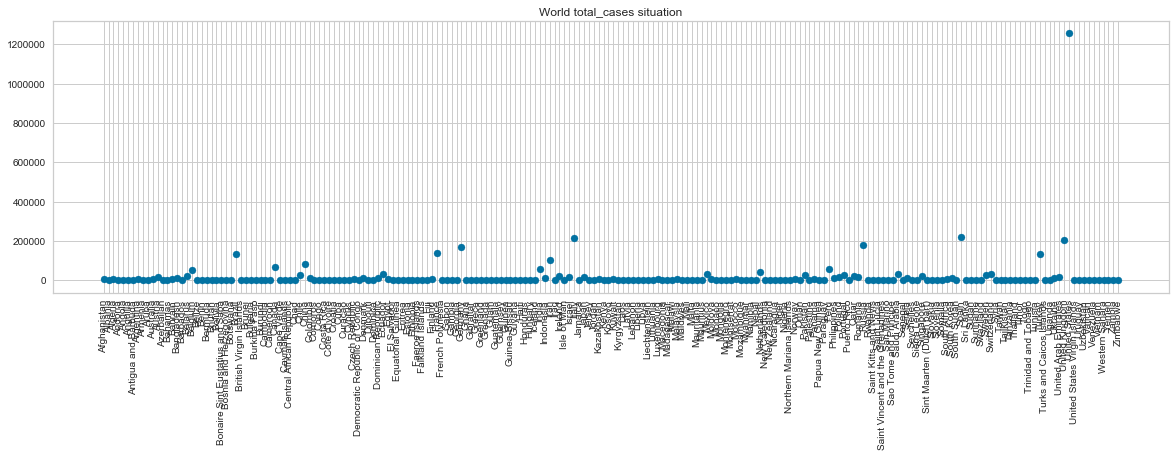

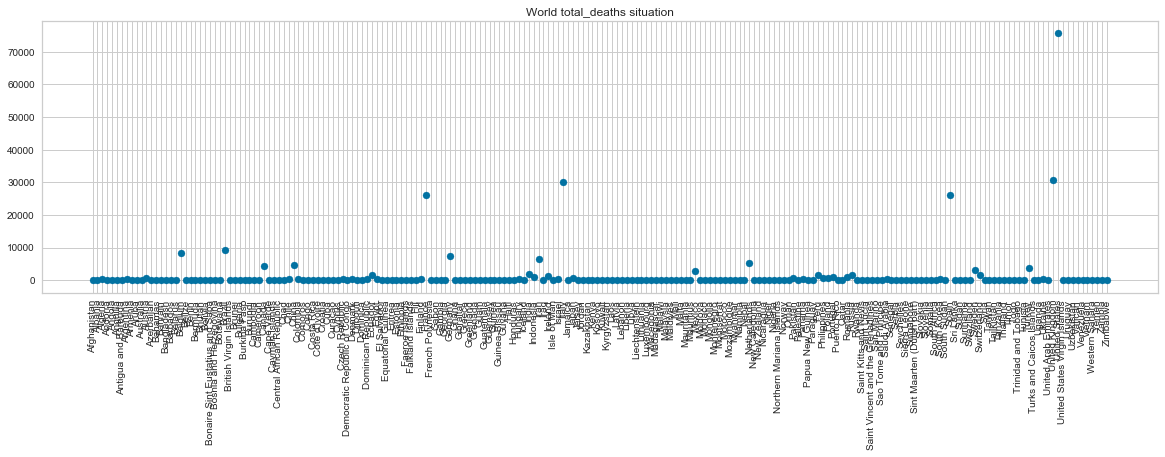

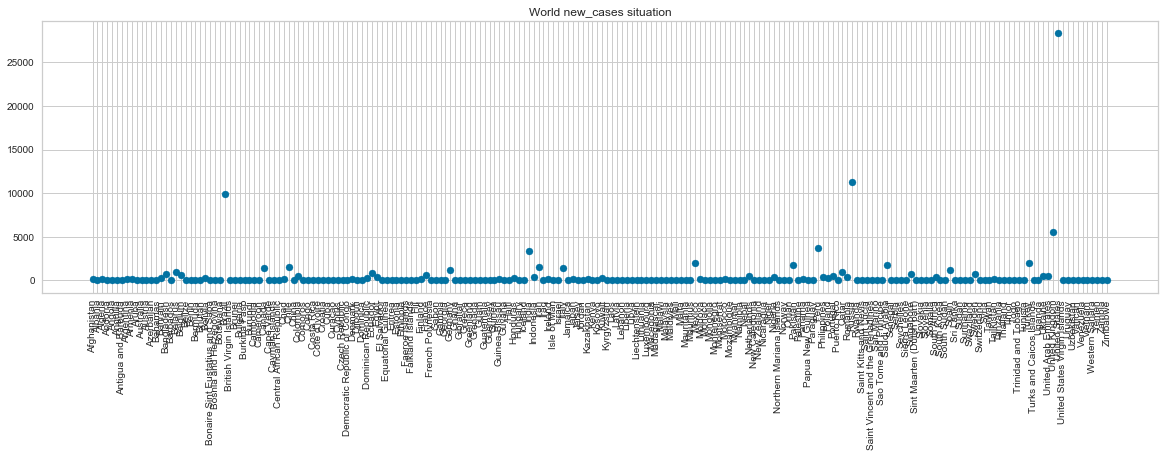

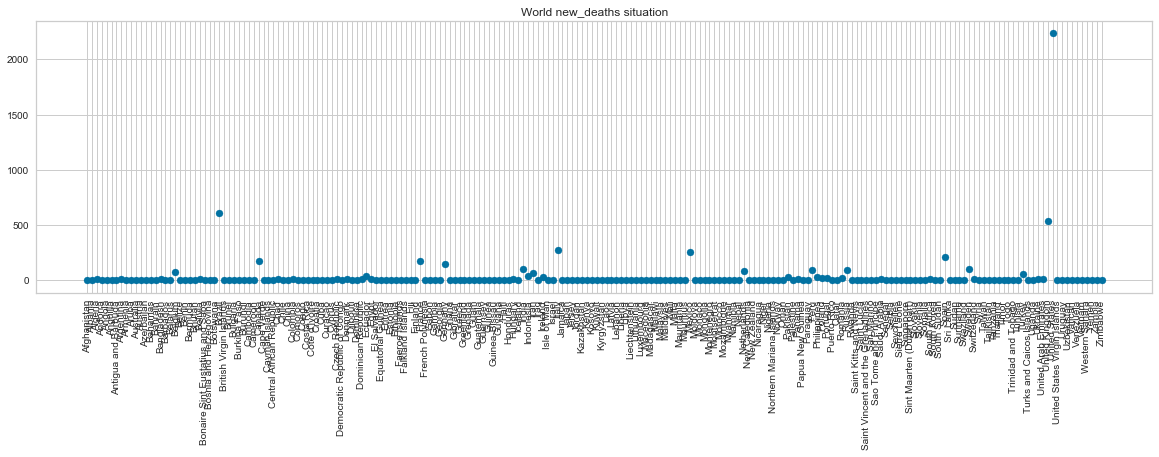

In [25]:
plotSituation("total_cases")
plotSituation("total_deaths")
plotSituation("new_cases")
plotSituation("new_deaths")

We can't read country but, this not the goal here, we will do this at the end with the clustering

In [26]:
## keep location in var before drop it
location = df["location"].values
df = df.drop(columns=["date","location"])

In [27]:
X = df.values

In [28]:
## init var of script
s_color = "#B32A4E"
seed = 69 
_k = 3

In [29]:
model = KMeans(n_clusters=_k, init='k-means++', max_iter=300, random_state=seed)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

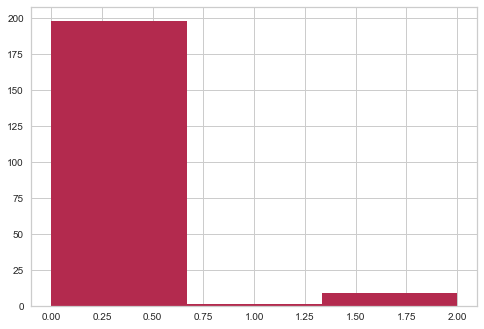

In [30]:
plt.hist(model.labels_, color=s_color, bins=_k)
plt.show()

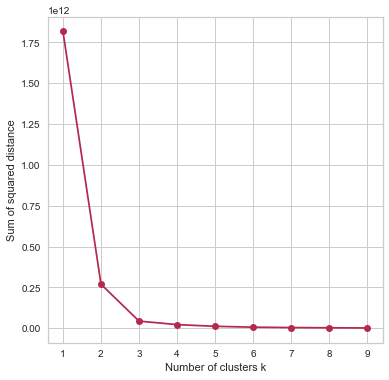

In [31]:
def bestk(): 
    """Run the Kmeans algorithm and get the index of data points clusters"""
    # never do that out of function and do not return any model from this ope
    sse = []
    list_k = list(range(1, 10))


    for k in list_k:
        ## must re create model, because K is not the _k choosen before and change at each iter
        model = KMeans(n_clusters=k, init='k-means++', max_iter=300,random_state=seed)
        model.fit(X)
        sse.append(model.inertia_)

    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o', color=s_color)
    plt.xlabel(r'Number of clusters k')
    plt.ylabel('Sum of squared distance');
    
bestk()    

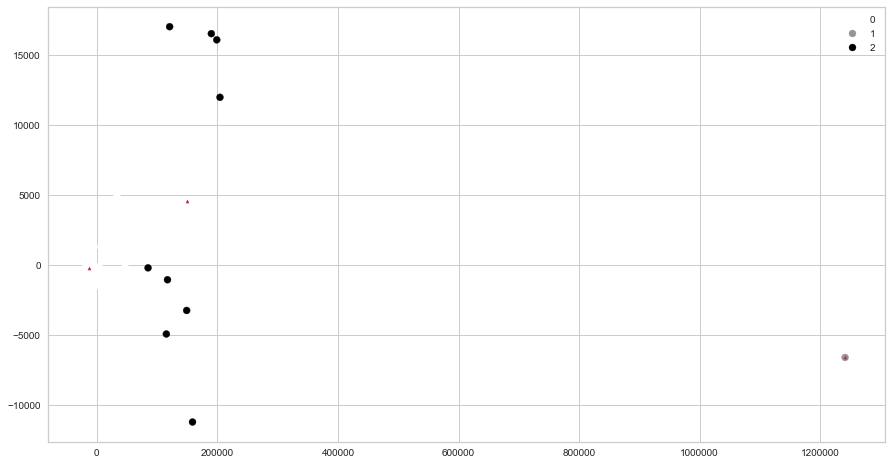

In [32]:
# reduce the features 
pca = PCA(n_components=2, random_state=seed)
reduced_features = pca.fit_transform(X)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model.cluster_centers_)

targets = ['0', '1', '2'] ## a way to factorize this ?? 

plt.figure(figsize=(15,8))
# plot the data
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=model.predict(X))
# plot the center of cluster
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker="^", s=10, c=s_color)
# plot the legend
plt.legend(handles=scatter.legend_elements()[0], labels=targets)

-- Details Explained variance ratio --
0.9992491311212799
0.0006813277893493504


Text(0, 0.5, 'variance %')

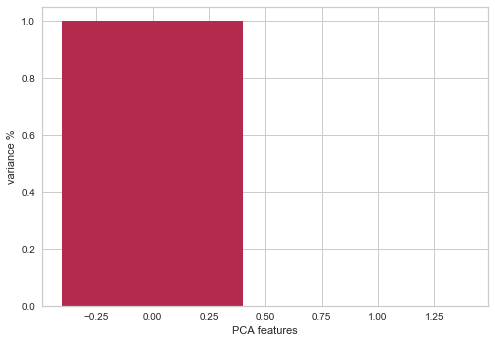

In [33]:
print("-- Details Explained variance ratio --")
for i in pca.explained_variance_ratio_:
    print(i)
    
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color=s_color)
plt.xlabel('PCA features')
plt.ylabel('variance %')

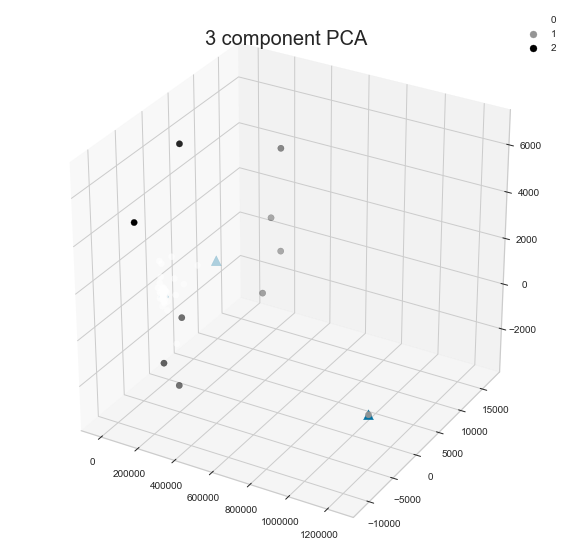

-- Details Explained variance ratio --
0.9992491311212799
0.0006813277893493504
6.938048911685316e-05


Text(0, 0.5, 'variance %')

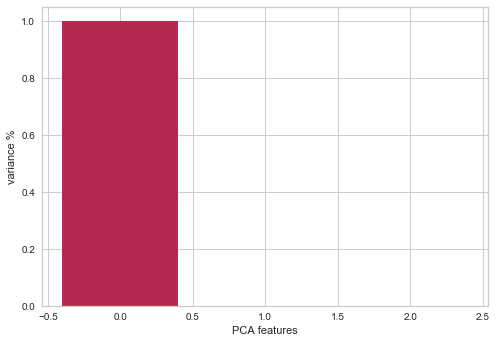

In [34]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3 component PCA', fontsize=20)

pca = PCA(n_components=3, random_state=seed)
reduced_features = pca.fit_transform(X)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model.cluster_centers_)

d=model.predict(X)
f = reduced_cluster_centers[:, 0]
g = reduced_cluster_centers[:, 1]
h = reduced_cluster_centers[:,2]

x = reduced_features[:, 0]
y = reduced_features[:, 1]
z = reduced_features[:, 2]

targets = ['0', '1', '2'] ## a way to factorize this ?? 

scatter = ax.scatter(x,y,z, s=40, c=d)
ax.scatter(f,g,h, marker="^", s=100, cmap=s_color)
ax.legend(handles=scatter.legend_elements()[0], labels=targets)
ax.grid()
plt.show()

print("-- Details Explained variance ratio --")
for i in pca.explained_variance_ratio_:
    print(i)
    
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color=s_color)
plt.xlabel('PCA features')
plt.ylabel('variance %')

In [35]:
# Creating an empty dictionary 
_3dClusterList = {} 
  
# Adding list's as value 
_3dClusterList["clusterSet"] = location
_3dClusterList["clusterX"] = x
_3dClusterList["clusterY"] = y
_3dClusterList["clusterZ"] = z

## I dump the data for each location with the 3 axes x,y,z for the real 3d volume on the app
dump(_3dClusterList, "endPoint/_3dClusterList.joblib")

['endPoint/_3dClusterList.joblib']

In [36]:
# print(_3dClusterList["clusterSet"][140])
# print(_3dClusterList["clusterX"][140])
# print(_3dClusterList["clusterY"][140])
# print(_3dClusterList["clusterZ"][140])

In [37]:
# The best value is 1 and the worst value is -1. 
# Values near 0 indicate overlapping clusters. 
# Negative values generally indicate that a sample has been assigned to the wrong cluster,
# as a different cluster is more similar.
silhouette_score(X, labels=model.predict(X))

0.9225542252463725

In [38]:
df["cluster"] = model.predict(df)
df["location"] = location

#  Conclusion

In [39]:
def seeCategories(df,num_cluster):
    """ show country concerned by each cluster """
    new_df = df[df['cluster'].isin([f"{num_cluster}"])]
    return new_df

In [40]:
seeCategories(df,2)

,new_cases,new_deaths,total_cases,total_deaths,cluster,location
2180,9888,610,135106,9146,2,Brazil
5180,629,178,137779,25987,2,France
5596,1209,147,167300,7266,2,Germany
6982,1485,68,103135,6486,2,Iran
7544,1401,274,215858,29958,2,Italy
12110,11231,88,177160,1625,2,Russia
13453,1122,213,221447,26070,2,Spain
14632,1977,57,133721,3641,2,Turkey
15035,5514,539,206715,30615,2,United Kingdom


In [41]:
seeCategories(df,0)

,new_cases,new_deaths,total_cases,total_deaths,cluster,location
119,171,2,3563,106,0,Afghanistan
180,10,0,842,31,0,Albania
305,185,7,5182,483,0,Algeria
361,1,1,752,47,0,Andorra
409,0,0,36,2,0,Angola
452,0,0,3,0,0,Anguilla
502,0,0,25,3,0,Antigua and Barbuda
565,163,9,5358,282,0,Argentina
686,102,2,2884,42,0,Armenia
733,0,1,101,3,0,Aruba


In [42]:
seeCategories(df,1)

,new_cases,new_deaths,total_cases,total_deaths,cluster,location
15165,28369,2239,1256972,75670,1,United States


In [43]:
from pycaret.datasets import get_data
from pycaret.clustering import *

In [44]:
data = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv", index_col=0)

In [45]:
data = data[data["date"].isin([f"{date.today()}"])] ## keep only row of today situation
i = data[data.location == 'World'].index ## find index of world row & drop them, i dont need it here
data = data.drop(i)

In [46]:
clu = setup(data, normalize=False)


Setup Succesfully Completed!


,Description,Value
0,session_id,7455
1,Original Data,"(208, 6)"
2,Missing Values,False
3,Numeric Features,4
4,Categorical Features,1
5,Ordinal Features,False
6,High Cardinality Features,False
7,Transformed Data,"(208, 216)"
8,Numeric Imputer,mean
9,Categorical Imputer,constant


In [47]:
kmeans = create_model('kmeans', num_clusters=3, verbose=True)

In [48]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=7455, tol=0.0001, verbose=0)

In [49]:
plot_model(kmeans)

In [50]:
plot_model(kmeans, plot = 'tsne')

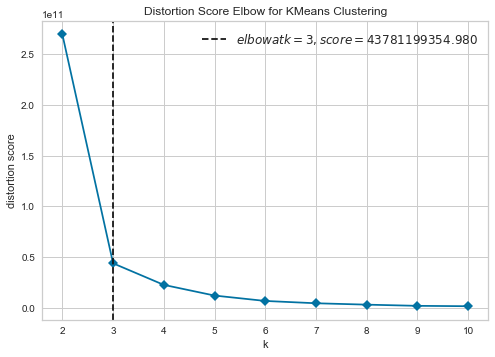

In [51]:
plot_model(kmeans, plot = 'elbow')

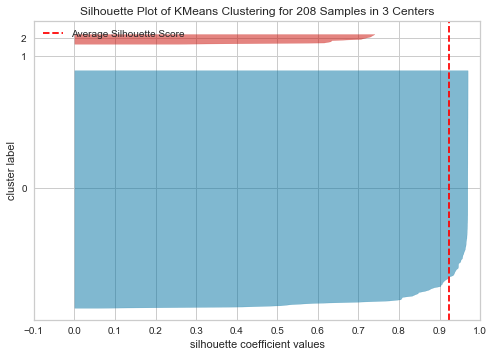

In [52]:
plot_model(kmeans, plot= 'silhouette')

In [53]:
plot_model(kmeans, plot = 'distribution', feature='total_deaths')

In [54]:
kmeans_results = assign_model(kmeans)
kmeans_results.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths,Cluster
119,2020-05-08,Afghanistan,171,2,3563,106,Cluster 0
180,2020-05-08,Albania,10,0,842,31,Cluster 0
305,2020-05-08,Algeria,185,7,5182,483,Cluster 0
361,2020-05-08,Andorra,1,1,752,47,Cluster 0
409,2020-05-08,Angola,0,0,36,2,Cluster 0


In [55]:
def seeCategories(df,num_cluster):
    """ show country concerned by each cluster """
    new_df = df[df['Cluster'].isin([f"{num_cluster}"])]
    return new_df

In [56]:
seeCategories(kmeans_results,"Cluster 0")

,date,location,new_cases,new_deaths,total_cases,total_deaths,Cluster
119,2020-05-08,Afghanistan,171,2,3563,106,Cluster 0
180,2020-05-08,Albania,10,0,842,31,Cluster 0
305,2020-05-08,Algeria,185,7,5182,483,Cluster 0
361,2020-05-08,Andorra,1,1,752,47,Cluster 0
409,2020-05-08,Angola,0,0,36,2,Cluster 0
452,2020-05-08,Anguilla,0,0,3,0,Cluster 0
502,2020-05-08,Antigua and Barbuda,0,0,25,3,Cluster 0
565,2020-05-08,Argentina,163,9,5358,282,Cluster 0
686,2020-05-08,Armenia,102,2,2884,42,Cluster 0
733,2020-05-08,Aruba,0,1,101,3,Cluster 0


In [57]:
seeCategories(kmeans_results,"Cluster 1")

,date,location,new_cases,new_deaths,total_cases,total_deaths,Cluster
15165,2020-05-08,United States,28369,2239,1256972,75670,Cluster 1


In [58]:
seeCategories(kmeans_results,"Cluster 2")

,date,location,new_cases,new_deaths,total_cases,total_deaths,Cluster
2180,2020-05-08,Brazil,9888,610,135106,9146,Cluster 2
5180,2020-05-08,France,629,178,137779,25987,Cluster 2
5596,2020-05-08,Germany,1209,147,167300,7266,Cluster 2
6982,2020-05-08,Iran,1485,68,103135,6486,Cluster 2
7544,2020-05-08,Italy,1401,274,215858,29958,Cluster 2
12110,2020-05-08,Russia,11231,88,177160,1625,Cluster 2
13453,2020-05-08,Spain,1122,213,221447,26070,Cluster 2
14632,2020-05-08,Turkey,1977,57,133721,3641,Cluster 2
15035,2020-05-08,United Kingdom,5514,539,206715,30615,Cluster 2
